## keypoint 다시 추출

In [ ]:
import os
import cv2
import csv
import mediapipe as mp
from tqdm import tqdm

# Mediapipe 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# 설정
base_path = '/content/images'  # *_frames 폴더들이 있는 경로
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나', '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
target_size = (480, 480)

for pose_name in pose_list:
    input_folder = os.path.join(base_path, f'{pose_name}_frames')
    output_csv = os.path.join(base_path, f'keypoints_{pose_name}.csv')

    if not os.path.exists(input_folder):
        print(f"❌ 폴더 없음: {input_folder}")
        continue

    image_files = sorted([f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.png'))])
    keypoints_data = []
    saved, skipped = 0, 0

    print(f"\n📂 [{pose_name}] {len(image_files)}장 이미지에서 keypoint 추출 중...")

    for fname in tqdm(image_files):
        image_path = os.path.join(input_folder, fname)
        image = cv2.imread(image_path)

        if image is None:
            continue

        image_resized = cv2.resize(image, target_size)
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            row = [fname]
            for lm in results.pose_landmarks.landmark:
                row.extend([lm.x, lm.y, lm.visibility])
            keypoints_data.append(row)
            saved += 1
        else:
            skipped += 1

    # CSV 저장
    header = ['filename']
    for i in range(33):
        header.extend([f'x{i}', f'y{i}', f'v{i}'])

    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(keypoints_data)

    print(f"✅ 저장 완료: {output_csv} (성공: {saved}, 실패: {skipped})")

print("\n🎯 원본 이미지(640x640)에서 keypoint 추출 완료!")


NotADirectoryError: [Errno 20] Not a directory: '/content/images/할라사나.jpg'

In [ ]:
import os
import cv2
import csv
import mediapipe as mp
from tqdm import tqdm

# Mediapipe 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# 설정
image_folder = '/content/images'  # 이미지들이 직접 있는 폴더
output_csv = os.path.join(image_folder, 'keypoints_all.csv')
target_size = (480, 480)

# 이미지 파일 수집
image_files = sorted([
    f for f in os.listdir(image_folder)
    if f.lower().endswith(('.jpg', '.png'))
])

keypoints_data = []
saved, skipped = 0, 0

print(f"📂 총 {len(image_files)}장 이미지에서 keypoint 추출 중...")

for fname in tqdm(image_files):
    image_path = os.path.join(image_folder, fname)
    image = cv2.imread(image_path)

    if image is None:
        print(f"⚠️ 이미지 읽기 실패: {fname}")
        skipped += 1
        continue

    image_resized = cv2.resize(image, target_size)
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        row = [fname]
        for lm in results.pose_landmarks.landmark:
            row.extend([lm.x, lm.y, lm.visibility])
        keypoints_data.append(row)
        saved += 1
    else:
        skipped += 1

# CSV 저장
header = ['filename']
for i in range(33):
    header.extend([f'x{i}', f'y{i}', f'v{i}'])

with open(output_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(keypoints_data)

print(f"\n✅ 저장 완료: {output_csv} (성공: {saved}, 실패: {skipped})")


📂 총 7장 이미지에서 keypoint 추출 중...


100%|██████████| 7/7 [00:00<00:00, 15.12it/s]


✅ 저장 완료: /content/images/keypoints_all.csv (성공: 7, 실패: 0)


In [ ]:
import os
import pandas as pd
import numpy as np

# ✅ 어깨+골반 기준 정규화 함수 (min_scale 적용)
def preprocess_keypoints_shoulder_hip(df, image_width=480, image_height=480,
                                      visibility_threshold=0.3, mask_value=-1.0, min_scale=20.0):
    vectors = []
    for _, row in df.iterrows():
        vector = []

        # 어깨, 골반 기준점 계산
        x11, y11, v11 = row['x11'] * image_width, row['y11'] * image_height, row['v11']
        x12, y12, v12 = row['x12'] * image_width, row['y12'] * image_height, row['v12']
        x23, y23, v23 = row['x23'] * image_width, row['y23'] * image_height, row['v23']
        x24, y24, v24 = row['x24'] * image_width, row['y24'] * image_height, row['v24']

        if min(v11, v12, v23, v24) >= visibility_threshold:
            shoulder_center = np.array([(x11 + x12) / 2, (y11 + y12) / 2])
            hip_center = np.array([(x23 + x24) / 2, (y23 + y24) / 2])
            center = (shoulder_center + hip_center) / 2
            scale = max(np.linalg.norm(shoulder_center - hip_center), min_scale)  # ✅ 최소 스케일 보장
        else:
            center, scale = None, None

        for i in range(33):
            x = row[f'x{i}'] * image_width
            y = row[f'y{i}'] * image_height
            v = row[f'v{i}']

            if v < visibility_threshold or center is None:
                x_out, y_out = mask_value, mask_value
            else:
                x_out = (x - center[0]) / scale
                y_out = (y - center[1]) / scale
            vector.extend([x_out, y_out, v])

        vectors.append(vector)
    return np.array(vectors)

# ✅ 단일 CSV 정규화 후 저장
def normalize_single_keypoint_csv(input_csv, output_csv):
    if not os.path.exists(input_csv):
        print(f"❌ 파일 없음: {input_csv}")
        return

    df = pd.read_csv(input_csv)
    filenames = df.iloc[:, 0].values.reshape(-1, 1)
    kp_vectors = preprocess_keypoints_shoulder_hip(df)

    df_out = pd.DataFrame(
        np.concatenate([filenames, kp_vectors], axis=1),
        columns=['filename'] + [f'{a}{i}' for i in range(33) for a in ['x', 'y', 'v']]
    )
    df_out.to_csv(output_csv, index=False, encoding='utf-8-sig')
    print(f"✅ 정규화 완료 → 저장: {output_csv}")



In [ ]:
input_csv = '/content/images/keypoints_all.csv'
output_csv = '/content/images/keypoints_all_norm.csv'

normalize_single_keypoint_csv(input_csv, output_csv)


✅ 정규화 완료 → 저장: /content/images/keypoints_all_norm.csv


In [ ]:
import os
import pandas as pd

# 설정
base_path = '/content/drive/MyDrive/yoga/training'  # *_frames 폴더 및 keypoints_*.csv 있는 경로
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나', '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']

for pose in pose_list:
    image_folder = os.path.join(base_path, f'{pose}_frames')
    csv_path = os.path.join(base_path, f'keypoints_{pose}.csv')

    if not os.path.exists(csv_path):
        print(f"❌ CSV 없음: {csv_path}")
        continue

    if not os.path.exists(image_folder):
        print(f"❌ 이미지 폴더 없음: {image_folder}")
        continue

    df = pd.read_csv(csv_path)
    used_filenames = set(df['filename'])

    deleted_count = 0

    for fname in os.listdir(image_folder):
        if fname.lower().endswith(('.jpg', '.png')) and fname not in used_filenames:
            os.remove(os.path.join(image_folder, fname))
            deleted_count += 1

    print(f"🧹 [{pose}] keypoint 없는 이미지 {deleted_count}장 삭제 완료")

print("\n✅ 모든 자세 폴더에서 불필요한 이미지 정리 완료!")


🧹 [할라사나] keypoint 없는 이미지 21장 삭제 완료
🧹 [나바사나] keypoint 없는 이미지 1장 삭제 완료
🧹 [아도 무카 스바나사나] keypoint 없는 이미지 6장 삭제 완료
🧹 [우스트라사나] keypoint 없는 이미지 2장 삭제 완료
🧹 [부장가사나] keypoint 없는 이미지 0장 삭제 완료
🧹 [비라바드라사나1] keypoint 없는 이미지 1장 삭제 완료
🧹 [비라바드라사나2] keypoint 없는 이미지 0장 삭제 완료

✅ 모든 자세 폴더에서 불필요한 이미지 정리 완료!


### 어깨만을 기준으로 정규화

In [ ]:
import os
import pandas as pd
import numpy as np

# ✅ 정규화 함수: 어깨 기준 + 최소 스케일 보장 + threshold=0.3
def preprocess_keypoints_with_pixels(df, image_width=480, image_height=480,
                                     visibility_threshold=0.3, mask_value=-1.0, min_scale=20.0):
    vectors = []
    for _, row in df.iterrows():
        vector = []

        # 좌우 어깨 기준
        x11 = row['x11'] * image_width
        x12 = row['x12'] * image_width
        y11 = row['y11'] * image_height
        y12 = row['y12'] * image_height
        v11, v12 = row['v11'], row['v12']

        if v11 >= visibility_threshold and v12 >= visibility_threshold:
            x_center = (x11 + x12) / 2
            y_center = (y11 + y12) / 2
            scale = np.linalg.norm([x11 - x12, y11 - y12])
            scale = max(scale, min_scale)
        else:
            x_center, y_center, scale = None, None, None

        for i in range(33):
            x = row[f'x{i}'] * image_width
            y = row[f'y{i}'] * image_height
            v = row[f'v{i}']

            if v < visibility_threshold or x_center is None:
                x_out, y_out = mask_value, mask_value
            else:
                x_out = (x - x_center) / scale
                y_out = (y - y_center) / scale

            vector.extend([x_out, y_out, v])
        vectors.append(vector)
    return np.array(vectors)

# ✅ 전체 CSV에 정규화 적용 후 저장
def save_all_processed_keypoints_pixel_norm(base_path, pose_list, output_suffix='_proc.csv'):
    os.makedirs(base_path, exist_ok=True)

    for pose in pose_list:
        src_path = os.path.join(base_path, f'keypoints_{pose}.csv')
        dst_path = os.path.join(base_path, f'keypoints_{pose}{output_suffix}')

        if not os.path.exists(src_path):
            print(f"❌ 파일 없음: {src_path}")
            continue

        df = pd.read_csv(src_path)
        filenames = df.iloc[:, 0]
        kp_vectors = preprocess_keypoints_with_pixels(df)

        col_names = ['filename'] + [f'{a}{i}' for i in range(33) for a in ['x', 'y', 'v']]
        df_out = pd.DataFrame(np.column_stack([filenames, kp_vectors]), columns=col_names)
        df_out.to_csv(dst_path, index=False, encoding='utf-8-sig')
        print(f"✅ 저장 완료: {dst_path}")

    print("\n📦 모든 keypoint 정규화 완료!")

# ✅ 실행
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나',
             '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
base_path = '/content/drive/MyDrive/yoga/training'

save_all_processed_keypoints_pixel_norm(base_path, pose_list)


✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_할라사나_proc.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_나바사나_proc.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_아도 무카 스바나사나_proc.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_우스트라사나_proc.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_부장가사나_proc.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_비라바드라사나1_proc.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_비라바드라사나2_proc.csv

📦 모든 keypoint 정규화 완료!


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# ✅ 이미지 로딩 함수
def load_image_cv2(img_path, img_size=(480, 480)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.astype(np.float32) / 255.0

# ✅ 개별 포즈 .npz 저장 함수
def save_pose_npz_from_proc_csv(pose, label, base_image_path, base_csv_path, output_folder, img_size=(480, 480)):
    csv_path = os.path.join(base_csv_path, f'keypoints_{pose}_proc.csv')
    image_dir = os.path.join(base_image_path, f'{pose}_frames')
    save_path = os.path.join(output_folder, f'{pose}.npz')

    if not (os.path.exists(csv_path) and os.path.exists(image_dir)):
        print(f"❌ 경로 확인 필요: {csv_path} 또는 {image_dir}")
        return 0

    df = pd.read_csv(csv_path)
    X_img, X_pose, y = [], [], []

    for _, row in df.iterrows():
        filename = row['filename']
        img_path = os.path.join(image_dir, filename)
        if not os.path.exists(img_path):
            continue

        img = load_image_cv2(img_path, img_size)
        if img is None:
            continue

        pose_vector = row.iloc[1:].to_numpy(dtype=np.float32)
        X_img.append(img)
        X_pose.append(pose_vector)
        y.append(label)

    if not X_img:
        print(f"⚠️ {pose} → 유효 이미지 없음")
        return 0

    np.savez_compressed(save_path,
                        X_img=np.array(X_img),
                        X_pose=np.array(X_pose),
                        y=np.array(y, dtype=np.int32))
    print(f"✅ 저장 완료: {pose} → {len(X_img)}개 → {save_path}")
    return len(X_img)

# ✅ 전체 포즈 실행
def convert_all_csv_to_npz(pose_list, base_image_path, base_csv_path, output_folder, img_size=(480, 480)):
    os.makedirs(output_folder, exist_ok=True)
    total = 0
    for label, pose in enumerate(pose_list):
        count = save_pose_npz_from_proc_csv(pose, label, base_image_path, base_csv_path, output_folder, img_size)
        total += count
    print(f"\n📦 총 변환 완료: {total}개")

# ✅ 실행
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나',
             '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
base_path = '/content/drive/MyDrive/yoga/training'
output_npz_path = os.path.join(base_path, 'npz_split')

convert_all_csv_to_npz(pose_list, base_path, base_path, output_npz_path, img_size=(480, 480))


✅ 저장 완료: 할라사나 → 1783개 → /content/drive/MyDrive/yoga/training/npz_split/할라사나.npz
✅ 저장 완료: 나바사나 → 1808개 → /content/drive/MyDrive/yoga/training/npz_split/나바사나.npz
✅ 저장 완료: 아도 무카 스바나사나 → 1808개 → /content/drive/MyDrive/yoga/training/npz_split/아도 무카 스바나사나.npz
✅ 저장 완료: 우스트라사나 → 1731개 → /content/drive/MyDrive/yoga/training/npz_split/우스트라사나.npz
✅ 저장 완료: 부장가사나 → 1803개 → /content/drive/MyDrive/yoga/training/npz_split/부장가사나.npz
✅ 저장 완료: 비라바드라사나1 → 1672개 → /content/drive/MyDrive/yoga/training/npz_split/비라바드라사나1.npz
✅ 저장 완료: 비라바드라사나2 → 1803개 → /content/drive/MyDrive/yoga/training/npz_split/비라바드라사나2.npz

📦 총 변환 완료: 12408개


In [ ]:
import os
import numpy as np
from collections import Counter

# ✅ 메모리 효율적인 병합 함수
def merge_npz_with_fixed_labels(npz_folder, output_path, pose_list):
    X_img_list, X_pose_list, y_list = [], [], []

    total_files = len(pose_list)
    print(f"📂 병합 시작 - 총 {total_files}개 포즈")

    for label, pose_name in enumerate(pose_list):
        file_path = os.path.join(npz_folder, f"{pose_name}.npz")
        if not os.path.exists(file_path):
            print(f"❌ 파일 없음: {file_path}")
            continue

        data = np.load(file_path)
        X_img = data["X_img"].astype(np.float32)
        X_pose = data["X_pose"].astype(np.float32)
        y = np.full(len(data["y"]), label, dtype=np.int32)  # ✅ 라벨 고정

        X_img_list.append(X_img)
        X_pose_list.append(X_pose)
        y_list.append(y)

        print(f"✅ ({label + 1}/{total_files}) {pose_name} - 샘플 수: {len(y)}")

    # 병합 및 저장
    X_img_all = np.concatenate(X_img_list, axis=0)
    X_pose_all = np.concatenate(X_pose_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    np.savez_compressed(output_path, X_img=X_img_all, X_pose=X_pose_all, y=y_all)

    print(f"\n📦 병합 완료: {output_path}")
    print("🧾 라벨 분포:", dict(Counter(y_all)))

# ✅ 실행 준비
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나',
             '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
npz_split_folder = '/content/drive/MyDrive/yoga/training/npz_split'
output_npz_path = '/content/drive/MyDrive/yoga/training/npz_output/all_poses_shoulder_fixed.npz'


### 어깨와 골반 기준 정규화

In [ ]:
import os
import pandas as pd
import numpy as np

# ✅ 골반+어깨 기준 keypoint 정규화 함수
def preprocess_keypoints_with_pixels(df, image_width=480, image_height=480,
                                     visibility_threshold=0.5, mask_value=-1.0):
    vectors = []
    for _, row in df.iterrows():
        vector = []

        # 좌우 어깨 (11, 12), 좌우 골반 (23, 24)
        x11, y11, v11 = row['x11'] * image_width, row['y11'] * image_height, row['v11']
        x12, y12, v12 = row['x12'] * image_width, row['y12'] * image_height, row['v12']
        x23, y23, v23 = row['x23'] * image_width, row['y23'] * image_height, row['v23']
        x24, y24, v24 = row['x24'] * image_width, row['y24'] * image_height, row['v24']

        # 중심 및 스케일 계산
        if min(v11, v12, v23, v24) >= visibility_threshold:
            shoulder_center = np.array([(x11 + x12) / 2, (y11 + y12) / 2])
            hip_center = np.array([(x23 + x24) / 2, (y23 + y24) / 2])
            center = (shoulder_center + hip_center) / 2
            scale = np.linalg.norm(shoulder_center - hip_center) + 1e-6
        else:
            center, scale = None, None

        for i in range(33):
            x = row[f'x{i}'] * image_width
            y = row[f'y{i}'] * image_height
            v = row[f'v{i}']

            if v < visibility_threshold or center is None:
                x_out, y_out = mask_value, mask_value
            else:
                x_out = (x - center[0]) / scale
                y_out = (y - center[1]) / scale
            vector.extend([x_out, y_out, v])
        vectors.append(vector)
    return np.array(vectors)


# ✅ 정규화 후 저장 함수
def save_all_processed_keypoints_pixel_norm(base_path, pose_list, output_suffix='_proc2.csv'):
    os.makedirs(base_path, exist_ok=True)

    for pose in pose_list:
        src_path = os.path.join(base_path, f'keypoints_{pose}.csv')
        dst_path = os.path.join(base_path, f'keypoints_{pose}{output_suffix}')

        if not os.path.exists(src_path):
            print(f"❌ 파일 없음: {src_path}")
            continue

        df = pd.read_csv(src_path)
        filenames = df.iloc[:, 0]
        kp_vectors = preprocess_keypoints_with_pixels(df)

        col_names = ['filename'] + [f'{a}{i}' for i in range(33) for a in ['x', 'y', 'v']]
        df_out = pd.DataFrame(np.column_stack([filenames, kp_vectors]), columns=col_names)
        df_out.to_csv(dst_path, index=False, encoding='utf-8-sig')
        print(f"✅ 저장 완료: {dst_path}")

    print("\n📦 모든 keypoint 전처리 파일 저장 완료!")


# ✅ 예시 실행용 pose 목록
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나', '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
base_path = '/content/drive/MyDrive/yoga/training'

# ✅ 실행
save_all_processed_keypoints_pixel_norm(base_path, pose_list)


✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_할라사나_proc2.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_나바사나_proc2.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_아도 무카 스바나사나_proc2.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_우스트라사나_proc2.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_부장가사나_proc2.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_비라바드라사나1_proc2.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_비라바드라사나2_proc2.csv

📦 모든 keypoint 전처리 파일 저장 완료!


In [ ]:
import os
import pandas as pd
import numpy as np

# ✅ 정규화 함수: 어깨+골반 기준 + threshold=0.3
def preprocess_keypoints_shoulder_hip(df, image_width=480, image_height=480,
                                      visibility_threshold=0.3, mask_value=-1.0):
    vectors = []
    for _, row in df.iterrows():
        vector = []

        # 어깨(11,12), 골반(23,24)
        x11, y11, v11 = row['x11'] * image_width, row['y11'] * image_height, row['v11']
        x12, y12, v12 = row['x12'] * image_width, row['y12'] * image_height, row['v12']
        x23, y23, v23 = row['x23'] * image_width, row['y23'] * image_height, row['v23']
        x24, y24, v24 = row['x24'] * image_width, row['y24'] * image_height, row['v24']

        # 중심점 및 스케일 계산
        if min(v11, v12, v23, v24) >= visibility_threshold:
            shoulder_center = np.array([(x11 + x12) / 2, (y11 + y12) / 2])
            hip_center = np.array([(x23 + x24) / 2, (y23 + y24) / 2])
            center = (shoulder_center + hip_center) / 2
            scale = np.linalg.norm(shoulder_center - hip_center) + 1e-6  # 나눗셈 방지
        else:
            center, scale = None, None

        for i in range(33):
            x = row[f'x{i}'] * image_width
            y = row[f'y{i}'] * image_height
            v = row[f'v{i}']

            if v < visibility_threshold or center is None:
                x_out, y_out = mask_value, mask_value
            else:
                x_out = (x - center[0]) / scale
                y_out = (y - center[1]) / scale
            vector.extend([x_out, y_out, v])
        vectors.append(vector)
    return np.array(vectors)

# ✅ 저장 함수
def save_all_processed_keypoints_shoulder_hip(base_path, pose_list, output_suffix='_proc2.csv'):
    os.makedirs(base_path, exist_ok=True)

    for pose in pose_list:
        src_path = os.path.join(base_path, f'keypoints_{pose}.csv')
        dst_path = os.path.join(base_path, f'keypoints_{pose}{output_suffix}')

        if not os.path.exists(src_path):
            print(f"❌ 파일 없음: {src_path}")
            continue

        df = pd.read_csv(src_path)
        filenames = df.iloc[:, 0]
        kp_vectors = preprocess_keypoints_shoulder_hip(df)

        col_names = ['filename'] + [f'{a}{i}' for i in range(33) for a in ['x', 'y', 'v']]
        df_out = pd.DataFrame(np.column_stack([filenames, kp_vectors]), columns=col_names)
        df_out.to_csv(dst_path, index=False, encoding='utf-8-sig')
        print(f"✅ 저장 완료: {dst_path}")

    print("\n📦 어깨+골반 기준 정규화 완료!")

# ✅ 실행
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나',
             '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
base_path = '/content/drive/MyDrive/yoga/training'

save_all_processed_keypoints_shoulder_hip(base_path, pose_list)


✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_할라사나_proc2.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_나바사나_proc2.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_아도 무카 스바나사나_proc2.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_우스트라사나_proc2.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_부장가사나_proc2.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_비라바드라사나1_proc2.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_비라바드라사나2_proc2.csv

📦 어깨+골반 기준 정규화 완료!


In [ ]:
import os
import pandas as pd
import numpy as np

# ✅ 어깨+골반 기준 정규화 함수
def preprocess_keypoints_shoulder_hip(df, image_width=480, image_height=480,
                                      visibility_threshold=0.3, mask_value=-1.0):
    vectors = []
    for _, row in df.iterrows():
        vector = []

        # 기준점 계산용 좌표 (픽셀)
        x11, y11, v11 = row['x11'] * image_width, row['y11'] * image_height, row['v11']
        x12, y12, v12 = row['x12'] * image_width, row['y12'] * image_height, row['v12']
        x23, y23, v23 = row['x23'] * image_width, row['y23'] * image_height, row['v23']
        x24, y24, v24 = row['x24'] * image_width, row['y24'] * image_height, row['v24']

        if min(v11, v12, v23, v24) >= visibility_threshold:
            shoulder_center = np.array([(x11 + x12) / 2, (y11 + y12) / 2])
            hip_center = np.array([(x23 + x24) / 2, (y23 + y24) / 2])
            center = (shoulder_center + hip_center) / 2
            scale = np.linalg.norm(shoulder_center - hip_center) + 1e-6
        else:
            center, scale = None, None

        for i in range(33):
            x = row[f'x{i}'] * image_width
            y = row[f'y{i}'] * image_height
            v = row[f'v{i}']
            if v < visibility_threshold or center is None:
                x_out, y_out = mask_value, mask_value
            else:
                x_out = (x - center[0]) / scale
                y_out = (y - center[1]) / scale
            vector.extend([x_out, y_out, v])

        vectors.append(vector)
    return np.array(vectors)

# ✅ keypoints/*.csv 하나씩 정규화해서 저장
def normalize_all_single_keypoint_csvs(input_folder, output_folder, suffix='_proc.csv'):
    os.makedirs(output_folder, exist_ok=True)

    files = sorted([f for f in os.listdir(input_folder) if f.endswith('.csv')])
    print(f"📂 총 {len(files)}개 keypoint CSV 정규화 시작")

    for file in files:
        src_path = os.path.join(input_folder, file)
        df = pd.read_csv(src_path)

        # 단일 프레임 CSV 파일일 경우 -> 1 row만 있을 것
        if df.shape[0] != 1:
            print(f"⚠️ 1행이 아닌 CSV 무시됨: {file}")
            continue

        kp_vector = preprocess_keypoints_shoulder_hip(df)  # shape: (1, 99)
        if kp_vector.shape[0] == 0:
            print(f"❌ 정규화 실패: {file}")
            continue

        # 파일 저장
        out_df = pd.DataFrame(kp_vector, columns=[f'{a}{i}' for i in range(33) for a in ['x', 'y', 'v']])
        out_name = os.path.splitext(file)[0] + suffix
        out_path = os.path.join(output_folder, out_name)
        out_df.to_csv(out_path, index=False)
        print(f"✅ 저장 완료: {out_name}")

    print("\n🎯 전체 정규화 완료!")

# ✅ 실행 경로 설정
input_folder = '/content/images/keypoints'
output_folder = '/content/images/keypoints_normalized'

normalize_all_single_keypoint_csvs(input_folder, output_folder)


📂 총 7개 keypoint CSV 정규화 시작
⚠️ 1행이 아닌 CSV 무시됨: 나바사나.csv
⚠️ 1행이 아닌 CSV 무시됨: 부장가사나.csv
⚠️ 1행이 아닌 CSV 무시됨: 비라바드라사나1.csv
⚠️ 1행이 아닌 CSV 무시됨: 비라바드라사나2.csv
⚠️ 1행이 아닌 CSV 무시됨: 아도 무카 스바나사나.csv
⚠️ 1행이 아닌 CSV 무시됨: 우스트라사나.csv
⚠️ 1행이 아닌 CSV 무시됨: 할라사나.csv

🎯 전체 정규화 완료!


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# ✅ 이미지 로딩 함수
def load_image_cv2(img_path, img_size=(480, 480)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.astype(np.float32) / 255.0

# ✅ 개별 포즈 .npz 저장 함수
def save_pose_npz_from_proc_csv(pose, label, base_image_path, base_csv_path, output_folder, img_size=(480, 480)):
    csv_path = os.path.join(base_csv_path, f'keypoints_{pose}_proc.csv')
    image_dir = os.path.join(base_image_path, f'{pose}_frames')
    save_path = os.path.join(output_folder, f'{pose}.npz')

    if not (os.path.exists(csv_path) and os.path.exists(image_dir)):
        print(f"❌ 경로 확인 필요: {csv_path} 또는 {image_dir}")
        return 0

    df = pd.read_csv(csv_path)
    X_img, X_pose, y = [], [], []

    for _, row in df.iterrows():
        filename = row['filename']
        img_path = os.path.join(image_dir, filename)
        if not os.path.exists(img_path):
            continue

        img = load_image_cv2(img_path, img_size)
        if img is None:
            continue

        pose_vector = row.iloc[1:].to_numpy(dtype=np.float32)
        X_img.append(img)
        X_pose.append(pose_vector)
        y.append(label)

    if not X_img:
        print(f"⚠️ {pose} → 유효 이미지 없음")
        return 0

    np.savez_compressed(save_path,
                        X_img=np.array(X_img),
                        X_pose=np.array(X_pose),
                        y=np.array(y, dtype=np.int32))
    print(f"✅ 저장 완료: {pose} → {len(X_img)}개 → {save_path}")
    return len(X_img)

# ✅ 전체 포즈 실행
def convert_all_csv_to_npz(pose_list, base_image_path, base_csv_path, output_folder, img_size=(480, 480)):
    os.makedirs(output_folder, exist_ok=True)
    total = 0
    for label, pose in enumerate(pose_list):
        count = save_pose_npz_from_proc_csv(pose, label, base_image_path, base_csv_path, output_folder, img_size)
        total += count
    print(f"\n📦 총 변환 완료: {total}개")

# ✅ 실행
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나',
             '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
base_path = '/content/drive/MyDrive/yoga/training'
output_npz_path = os.path.join(base_path, 'npz_split/plus')

convert_all_csv_to_npz(pose_list, base_path, base_path, output_npz_path, img_size=(480, 480))


✅ 저장 완료: 할라사나 → 1783개 → /content/drive/MyDrive/yoga/training/npz_split/plus/할라사나.npz
✅ 저장 완료: 나바사나 → 1808개 → /content/drive/MyDrive/yoga/training/npz_split/plus/나바사나.npz
✅ 저장 완료: 아도 무카 스바나사나 → 1808개 → /content/drive/MyDrive/yoga/training/npz_split/plus/아도 무카 스바나사나.npz
✅ 저장 완료: 우스트라사나 → 1731개 → /content/drive/MyDrive/yoga/training/npz_split/plus/우스트라사나.npz
✅ 저장 완료: 부장가사나 → 1803개 → /content/drive/MyDrive/yoga/training/npz_split/plus/부장가사나.npz
✅ 저장 완료: 비라바드라사나1 → 1672개 → /content/drive/MyDrive/yoga/training/npz_split/plus/비라바드라사나1.npz
✅ 저장 완료: 비라바드라사나2 → 1803개 → /content/drive/MyDrive/yoga/training/npz_split/plus/비라바드라사나2.npz

📦 총 변환 완료: 12408개


In [ ]:
import os
import numpy as np
from collections import Counter

# ✅ 메모리 효율적인 병합 함수
def merge_npz_with_fixed_labels(npz_folder, output_path, pose_list):
    X_img_list, X_pose_list, y_list = [], [], []

    total_files = len(pose_list)
    print(f"📂 병합 시작 - 총 {total_files}개 포즈")

    for label, pose_name in enumerate(pose_list):
        file_path = os.path.join(npz_folder, f"{pose_name}.npz")
        if not os.path.exists(file_path):
            print(f"❌ 파일 없음: {file_path}")
            continue

        data = np.load(file_path)
        X_img = data["X_img"].astype(np.float32)
        X_pose = data["X_pose"].astype(np.float32)
        y = np.full(len(data["y"]), label, dtype=np.int32)  # ✅ 라벨 고정

        X_img_list.append(X_img)
        X_pose_list.append(X_pose)
        y_list.append(y)

        print(f"✅ ({label + 1}/{total_files}) {pose_name} - 샘플 수: {len(y)}")

    # 병합 및 저장
    X_img_all = np.concatenate(X_img_list, axis=0)
    X_pose_all = np.concatenate(X_pose_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    np.savez_compressed(output_path, X_img=X_img_all, X_pose=X_pose_all, y=y_all)

    print(f"\n📦 병합 완료: {output_path}")
    print("🧾 라벨 분포:", dict(Counter(y_all)))

# ✅ 실행 준비
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나',
             '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
npz_split_folder = '/content/drive/MyDrive/yoga/training/npz_split/plus'
output_npz_path = '/content/drive/MyDrive/yoga/training/npz_output/all_poses_shoulderplus_fixed.npz'


In [ ]:
!ls '/content/drive/MyDrive/yoga/training'


 keypoints_나바사나.csv			    keypoints_할라사나.csv
 keypoints_나바사나_proc.csv		    keypoints_할라사나_proc.csv
 keypoints_부장가사나.csv		    npz_output
 keypoints_부장가사나_proc.csv		    나바사나_frames
 keypoints_비라바드라사나1.csv		    부장가사나_frames
 keypoints_비라바드라사나1_proc.csv	    비라바드라사나1_frames
 keypoints_비라바드라사나2.csv		    비라바드라사나2_frames
 keypoints_비라바드라사나2_proc.csv	   '아도 무카 스바나사나_frames'
'keypoints_아도 무카 스바나사나.csv'	    우스트라사나_frames
'keypoints_아도 무카 스바나사나_proc.csv'   할라사나_frames
 keypoints_우스트라사나.csv		    할라사나_keypoints.mp4
 keypoints_우스트라사나_proc.csv


In [ ]:
!pip install tensorflow

## npz 파일 만들기

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2

# ✅ 이미지 로딩 함수
def load_image_cv2(img_path, img_size):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.astype(np.float32) / 255.0

# ✅ 병합 없이 각 포즈별 npz 저장 + 진행률 출력 (RAM 최적화 & 빠른 처리)
def save_all_pose_npz_individual(pose_list, base_image_path, base_csv_path, output_folder, img_size=(480,480)):
    os.makedirs(output_folder, exist_ok=True)
    results = []

    for label, pose in enumerate(pose_list):
        csv_path = os.path.join(base_csv_path, f'keypoints_{pose}_proc2.csv')
        image_dir = os.path.join(base_image_path, f'{pose}_frames')
        save_path = os.path.join(output_folder, f'{pose}2.npz')

        if not (os.path.exists(csv_path) and os.path.exists(image_dir)):
            results.append((pose, "❌ 파일 없음", 0))
            continue

        df = pd.read_csv(csv_path)
        filenames = df['filename'].tolist()
        pose_vectors = df.iloc[:, 1:].astype(np.float32).values

        X_img, X_pose, y = [], [], []
        total = len(filenames)
        last_printed_percent = -1

        for idx, (fname, vector) in enumerate(zip(filenames, pose_vectors)):
            img_path = os.path.join(image_dir, fname)
            img = load_image_cv2(img_path, img_size)
            if img is None:
                continue
            X_img.append(img)
            X_pose.append(vector)
            y.append(label)

            # ✅ 퍼센트 단위 출력 (10% 단위로만)
            percent = int((idx + 1) / total * 100)
            if percent % 10 == 0 and percent != last_printed_percent:
                print(f"⏳ {pose} 진행률: {percent}%")
                last_printed_percent = percent

        if not X_img:
            results.append((pose, "⚠️ 유효 이미지 없음", 0))
            continue

        np.savez_compressed(save_path,
                            X_img=np.array(X_img),
                            X_pose=np.array(X_pose),
                            y=np.array(y, dtype=np.int32))
        results.append((pose, "✅ 저장 완료", len(X_img)))

    return pd.DataFrame(results, columns=["자세", "상태", "샘플 수"])


# ✅ 실행 파라미터
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나',
             '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
base_image_path = '/content/drive/MyDrive/yoga/training'
base_csv_path = '/content/drive/MyDrive/yoga/training'
output_folder = '/content/drive/MyDrive/yoga/training/npz_split'

# ✅ 실행
df_result = save_all_pose_npz_individual(pose_list, base_image_path, base_csv_path, output_folder, img_size=(480, 480))


⏳ 할라사나 진행률: 0%
⏳ 할라사나 진행률: 10%
⏳ 할라사나 진행률: 20%
⏳ 할라사나 진행률: 30%
⏳ 할라사나 진행률: 40%
⏳ 할라사나 진행률: 50%
⏳ 할라사나 진행률: 60%
⏳ 할라사나 진행률: 70%
⏳ 할라사나 진행률: 80%
⏳ 할라사나 진행률: 90%
⏳ 할라사나 진행률: 100%
⏳ 나바사나 진행률: 0%
⏳ 나바사나 진행률: 10%
⏳ 나바사나 진행률: 20%
⏳ 나바사나 진행률: 30%
⏳ 나바사나 진행률: 40%
⏳ 나바사나 진행률: 50%
⏳ 나바사나 진행률: 60%
⏳ 나바사나 진행률: 70%
⏳ 나바사나 진행률: 80%
⏳ 나바사나 진행률: 90%
⏳ 나바사나 진행률: 100%
⏳ 아도 무카 스바나사나 진행률: 0%
⏳ 아도 무카 스바나사나 진행률: 10%
⏳ 아도 무카 스바나사나 진행률: 20%
⏳ 아도 무카 스바나사나 진행률: 30%
⏳ 아도 무카 스바나사나 진행률: 40%
⏳ 아도 무카 스바나사나 진행률: 50%
⏳ 아도 무카 스바나사나 진행률: 60%
⏳ 아도 무카 스바나사나 진행률: 70%
⏳ 아도 무카 스바나사나 진행률: 80%
⏳ 아도 무카 스바나사나 진행률: 90%
⏳ 아도 무카 스바나사나 진행률: 100%
⏳ 우스트라사나 진행률: 0%
⏳ 우스트라사나 진행률: 10%
⏳ 우스트라사나 진행률: 20%
⏳ 우스트라사나 진행률: 30%
⏳ 우스트라사나 진행률: 40%
⏳ 우스트라사나 진행률: 50%
⏳ 우스트라사나 진행률: 60%
⏳ 우스트라사나 진행률: 70%
⏳ 우스트라사나 진행률: 80%
⏳ 우스트라사나 진행률: 90%
⏳ 우스트라사나 진행률: 100%
⏳ 부장가사나 진행률: 0%
⏳ 부장가사나 진행률: 10%
⏳ 부장가사나 진행률: 20%
⏳ 부장가사나 진행률: 30%
⏳ 부장가사나 진행률: 40%
⏳ 부장가사나 진행률: 50%
⏳ 부장가사나 진행률: 60%
⏳ 부장가사나 진행률: 70%
⏳ 부장가사나 진행률: 80%
⏳ 부장가사나 진행률: 90%
⏳ 부장가사나 진행률: 100%
⏳ 비라바드라사나1

In [ ]:
import os
import numpy as np
from collections import Counter

def merge_npz_with_fixed_labels(npz_folder, output_path, pose_list):
    X_img_list, X_pose_list, y_list = [], [], []

    total_files = len(pose_list)
    print(f"📂 병합 시작 - 총 {total_files}개 포즈")

    for label, pose_name in enumerate(pose_list):
        file_path = os.path.join(npz_folder, f"{pose_name}.npz")
        if not os.path.exists(file_path):
            print(f"❌ 파일 없음: {file_path}")
            continue

        data = np.load(file_path)
        X_img = data["X_img"].astype(np.float32)
        X_pose = data["X_pose"].astype(np.float32)
        y = np.full(len(data["y"]), label, dtype=np.int32)  # ✅ 라벨 재정의

        X_img_list.append(X_img)
        X_pose_list.append(X_pose)
        y_list.append(y)

        print(f"✅ ({label + 1}/{total_files}) {pose_name} - 샘플 수: {len(y)}")

    X_img_all = np.concatenate(X_img_list, axis=0)
    X_pose_all = np.concatenate(X_pose_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)

    # 저장
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    np.savez_compressed(output_path, X_img=X_img_all, X_pose=X_pose_all, y=y_all)

    print(f"\n📦 병합 완료: {output_path}")
    print("🧾 라벨 분포:", dict(Counter(y_all)))

# ✅ 실행 예시
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나',
             '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
npz_split_folder = '/content/drive/MyDrive/yoga/training/npz_split/'
output_npz_path = '/content/drive/MyDrive/yoga/training/npz_output/all_poses_fixed.npz'

merge_npz_with_fixed_labels(npz_split_folder, output_npz_path, pose_list)


📂 병합 시작 - 총 7개 포즈
✅ (1/7) 할라사나 - 샘플 수: 1783
✅ (2/7) 나바사나 - 샘플 수: 1808
✅ (3/7) 아도 무카 스바나사나 - 샘플 수: 1808
✅ (4/7) 우스트라사나 - 샘플 수: 1731
✅ (5/7) 부장가사나 - 샘플 수: 1803
✅ (6/7) 비라바드라사나1 - 샘플 수: 1672
✅ (7/7) 비라바드라사나2 - 샘플 수: 1803

📦 병합 완료: /content/drive/MyDrive/yoga/training/npz_output/all_poses_fixed.npz
🧾 라벨 분포: {np.int32(0): 1783, np.int32(1): 1808, np.int32(2): 1808, np.int32(3): 1731, np.int32(4): 1803, np.int32(5): 1672, np.int32(6): 1803}


In [ ]:
import os
import numpy as np
from collections import Counter

def merge_npz_with_fixed_labels(npz_folder, output_path, pose_list):
    X_img_list, X_pose_list, y_list = [], [], []

    total_files = len(pose_list)
    print(f"📂 병합 시작 - 총 {total_files}개 포즈")

    for label, pose_name in enumerate(pose_list):
        file_path = os.path.join(npz_folder, f"{pose_name}.npz")
        if not os.path.exists(file_path):
            print(f"❌ 파일 없음: {file_path}")
            continue

        data = np.load(file_path)
        X_img = data["X_img"].astype(np.float32)
        X_pose = data["X_pose"].astype(np.float32)
        y = np.full(len(data["y"]), label, dtype=np.int32)  # ✅ 라벨 재정의

        X_img_list.append(X_img)
        X_pose_list.append(X_pose)
        y_list.append(y)

        print(f"✅ ({label + 1}/{total_files}) {pose_name} - 샘플 수: {len(y)}")

    X_img_all = np.concatenate(X_img_list, axis=0)
    X_pose_all = np.concatenate(X_pose_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)

    # 저장
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    np.savez_compressed(output_path, X_img=X_img_all, X_pose=X_pose_all, y=y_all)

    print(f"\n📦 병합 완료: {output_path}")
    print("🧾 라벨 분포:", dict(Counter(y_all)))

# ✅ 실행 예시
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나',
             '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
npz_split_folder = '/content/drive/MyDrive/yoga/training/npz_split/plus'
output_npz_path = '/content/drive/MyDrive/yoga/training/npz_output/all_poses_plus_fixed.npz'

merge_npz_with_fixed_labels(npz_split_folder, output_npz_path, pose_list)


📂 병합 시작 - 총 7개 포즈
✅ (1/7) 할라사나 - 샘플 수: 1783
✅ (2/7) 나바사나 - 샘플 수: 1808
✅ (3/7) 아도 무카 스바나사나 - 샘플 수: 1808
✅ (4/7) 우스트라사나 - 샘플 수: 1731
✅ (5/7) 부장가사나 - 샘플 수: 1803
✅ (6/7) 비라바드라사나1 - 샘플 수: 1672
✅ (7/7) 비라바드라사나2 - 샘플 수: 1803

📦 병합 완료: /content/drive/MyDrive/yoga/training/npz_output/all_poses_plus_fixed.npz
🧾 라벨 분포: {np.int32(0): 1783, np.int32(1): 1808, np.int32(2): 1808, np.int32(3): 1731, np.int32(4): 1803, np.int32(5): 1672, np.int32(6): 1803}


In [ ]:
!pip install tensorflow

## 어깨만 중심으로 잡았을 때

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from collections import Counter

# ✅ 제너레이터 클래스
class NPZBatchGenerator(Sequence):
    def __init__(self, X_img, X_pose, y, batch_size=16, shuffle=True):
        self.X_img = X_img
        self.X_pose = X_pose
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(y))
        if shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        return {
            'image_input': self.X_img[batch_indices],
            'keypoint_input': self.X_pose[batch_indices]
        }, self.y[batch_indices]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# ✅ 모델 구성
def build_model(input_shape=(480, 480, 3), pose_shape=(99,), num_classes=7):
    img_input = Input(shape=input_shape, name='image_input')
    pose_input = Input(shape=pose_shape, name='keypoint_input')

    base_model = MobileNetV2(include_top=False, input_tensor=img_input, weights='imagenet', alpha=0.75)
    x_img = GlobalAveragePooling2D()(base_model.output)
    x_img = BatchNormalization()(x_img)

    x_pose = Dense(128, activation='relu')(pose_input)
    x_pose = BatchNormalization()(x_pose)
    x_pose = Dropout(0.5)(x_pose)

    x = Concatenate()([x_img, x_pose])
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=[img_input, pose_input], outputs=output)

# ✅ 학습 함수
def train_with_generator(npz_path, batch_size=16, epochs=80, lr=3e-4):
    data = np.load(npz_path, mmap_mode='r')  # ✅ RAM 아끼기 위해 mmap_mode 사용
    X_img, X_pose, y = data['X_img'], data['X_pose'], data['y']

    print("📊 라벨 분포:", dict(Counter(y)))

    X_img_train, X_img_val, X_pose_train, X_pose_val, y_train, y_val = train_test_split(
        X_img, X_pose, y, test_size=0.2, stratify=y, random_state=42
    )

    train_gen = NPZBatchGenerator(X_img_train, X_pose_train, y_train, batch_size=batch_size)
    val_gen = NPZBatchGenerator(X_img_val, X_pose_val, y_val, batch_size=batch_size, shuffle=False)

    model = build_model(input_shape=(480, 480, 3), pose_shape=(99,), num_classes=7)
    model.compile(optimizer=Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint(npz_path.replace('.npz', '_best_model.keras'), save_best_only=True),
        ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
    ]

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks)
    return model, history


## 어깨 + 골반

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from collections import Counter

# ✅ 제너레이터 클래스
class NPZBatchGenerator(Sequence):
    def __init__(self, X_img, X_pose, y, batch_size=16, shuffle=True):
        self.X_img = X_img
        self.X_pose = X_pose
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(y))
        if shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        return {
            'image_input': self.X_img[batch_indices],
            'keypoint_input': self.X_pose[batch_indices]
        }, self.y[batch_indices]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# ✅ 모델 구성
def build_model(input_shape=(480, 480, 3), pose_shape=(99,), num_classes=7):
    img_input = Input(shape=input_shape, name='image_input')
    pose_input = Input(shape=pose_shape, name='keypoint_input')

    base_model = MobileNetV2(include_top=False, input_tensor=img_input, weights='imagenet', alpha=0.75)
    x_img = GlobalAveragePooling2D()(base_model.output)
    x_img = BatchNormalization()(x_img)

    x_pose = Dense(128, activation='relu')(pose_input)
    x_pose = BatchNormalization()(x_pose)
    x_pose = Dropout(0.5)(x_pose)

    x = Concatenate()([x_img, x_pose])
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=[img_input, pose_input], outputs=output)

# ✅ 학습 함수
def train_with_generator(npz_path, batch_size=16, epochs=80, lr=3e-4):
    data = np.load(npz_path, mmap_mode='r')  # ✅ RAM 아끼기 위해 mmap_mode 사용
    X_img, X_pose, y = data['X_img'], data['X_pose'], data['y']

    print("📊 라벨 분포:", dict(Counter(y)))

    X_img_train, X_img_val, X_pose_train, X_pose_val, y_train, y_val = train_test_split(
        X_img, X_pose, y, test_size=0.2, stratify=y, random_state=42
    )

    train_gen = NPZBatchGenerator(X_img_train, X_pose_train, y_train, batch_size=batch_size)
    val_gen = NPZBatchGenerator(X_img_val, X_pose_val, y_val, batch_size=batch_size, shuffle=False)

    model = build_model(input_shape=(480, 480, 3), pose_shape=(99,), num_classes=7)
    model.compile(optimizer=Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint(npz_path.replace('.npz', '_best_model_plus.keras'), save_best_only=True),
        ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
    ]

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks)
    return model, history


In [ ]:
train_with_generator(
    npz_path='/content/drive/MyDrive/yoga/training/npz_output/all_poses_plus_fixed.npz',
    batch_size=16,
    epochs=80
)


📊 라벨 분포: {np.int32(0): 1742, np.int32(1): 1795, np.int32(2): 1771, np.int32(3): 1679, np.int32(4): 1736, np.int32(5): 1639, np.int32(6): 1744}


<ipython-input-6-f680db271ebe>:44: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=img_input, weights='imagenet', alpha=0.75)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
606/606 ━━━━━━━━━━━━━━━━━━━━ 153s 137ms/step - accuracy: 0.9000 - loss: 0.3346 - val_accuracy: 0.7325 - val_loss: 1.3020 - learning_rate: 3.0000e-04
Epoch 2/80
606/606 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.9904 - loss: 0.0415 - val_accuracy: 0.6899 - val_loss: 2.4622 - learning_rate: 3.0000e-04
Epoch 3/80
606/606 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.9976 - loss: 0.0209 - val_accuracy: 0.9744 - val_loss: 0.0596 - learning_rate: 3.0000e-04
Epoch 4/80
606/606 ━━━━━━━━━━━━━━━━━━━━ 37s 61ms/step - accuracy: 0.9928 - loss: 0.0391 - val_accuracy: 0.9422 - val_loss: 0.1848 - learning_rate: 3.0000e-04
Epoch 5/80
606/606 ━━━━━━━━━━━━━━━━━━━━ 37s 61ms/step - accuracy: 0.9961 - loss: 0.0303 - val_accuracy: 0.6144 - val_loss: 3.6795 - learning_rate: 3.0000e-04
Epoch 6/80
606/606 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - accuracy: 0.9972 - loss: 0.0264 - val_accuracy: 0.9992 - val_loss: 0.0207 - learning_rate: 3.0000e-04
Epoch 7/80
606/606 ━━━━━━━━━━━━━━━━━━━━ 37s 61ms/s

(<Functional name=functional, built=True>,
 <keras.src.callbacks.history.History at 0x7d68086e4e90>)

In [ ]:
train_with_generator(
    npz_path='/content/drive/MyDrive/yoga/training/npz_output/all_poses_plus_fixed.npz',
    batch_size=16,
    epochs=80
)


📊 라벨 분포: {np.int32(0): 1783, np.int32(1): 1808, np.int32(2): 1808, np.int32(3): 1731, np.int32(4): 1803, np.int32(5): 1672, np.int32(6): 1803}


<ipython-input-2-f680db271ebe>:44: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=img_input, weights='imagenet', alpha=0.75)


Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


621/621 ━━━━━━━━━━━━━━━━━━━━ 150s 131ms/step - accuracy: 0.8920 - loss: 0.3671 - val_accuracy: 0.9351 - val_loss: 0.4906 - learning_rate: 3.0000e-04
Epoch 2/80
621/621 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.9872 - loss: 0.0547 - val_accuracy: 0.9637 - val_loss: 0.1082 - learning_rate: 3.0000e-04
Epoch 3/80
621/621 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.9861 - loss: 0.0639 - val_accuracy: 0.9879 - val_loss: 0.0606 - learning_rate: 3.0000e-04
Epoch 4/80
621/621 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.9944 - loss: 0.0324 - val_accuracy: 0.9545 - val_loss: 0.2719 - learning_rate: 3.0000e-04
Epoch 5/80
621/621 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.9932 - loss: 0.0297 - val_accuracy: 0.7200 - val_loss: 2.4579 - learning_rate: 3.0000e-04
Epoch 6/80
621/621 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.9885 - loss: 0.0592 - val_accuracy: 0.9976 - val_loss: 0.0244 - learning_rate: 3.0000e-04
Epoch 7/80
621/621 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accur

(<Functional name=functional, built=True>,
 <keras.src.callbacks.history.History at 0x7db6d80e2a10>)

In [ ]:
np.bincount(y)

array([1749, 1795, 1773, 1679, 1738, 1639, 1744])

### 멀티모달 예측해보기

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model

# ✅ 설정
IMAGE_DIR = '/content/'
MODEL_PATH = '/content/drive/MyDrive/yoga/training/npz_output/all_poses_plus_fixed_best_model_plus.keras'
IMAGE_SIZE = 480
POSE_LABELS = ['할라사나', '나바사나', '아도 무카 스바나사나', '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']

# ✅ 모델 로딩
model = load_model(MODEL_PATH)

# ✅ Mediapipe 초기화
mp_pose = mp.solutions.pose
pose_detector = mp_pose.Pose(static_image_mode=True)

# ✅ 골반+어깨 기준 정규화 함수
def normalize_keypoints_pelvis_shoulder(kpts, image_width=480, image_height=480,
                                        threshold=0.3, mask_value=-1.0):
    # 기준점 추출
    x11, y11, v11 = kpts[11]
    x12, y12, v12 = kpts[12]
    x23, y23, v23 = kpts[23]
    x24, y24, v24 = kpts[24]

    x11, y11 = x11 * image_width, y11 * image_height
    x12, y12 = x12 * image_width, y12 * image_height
    x23, y23 = x23 * image_width, y23 * image_height
    x24, y24 = x24 * image_width, y24 * image_height

    # 중심 및 스케일 계산
    if min(v11, v12, v23, v24) >= threshold:
        shoulder_center = np.array([(x11 + x12) / 2, (y11 + y12) / 2])
        hip_center = np.array([(x23 + x24) / 2, (y23 + y24) / 2])
        center = (shoulder_center + hip_center) / 2
        scale = np.linalg.norm(shoulder_center - hip_center) + 1e-6
    else:
        center, scale = None, None

    # 정규화 벡터 생성
    vector = []
    for i in range(33):
        x, y, v = kpts[i]
        x *= image_width
        y *= image_height

        if v < threshold or center is None:
            x_out, y_out = mask_value, mask_value
        else:
            x_out = (x - center[0]) / scale
            y_out = (y - center[1]) / scale

        vector.extend([x_out, y_out, v])

    return np.array(vector, dtype=np.float32)

# ✅ keypoint 추출
def extract_keypoints_from_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None, None
    img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = pose_detector.process(img_rgb)
    if not results.pose_landmarks:
        return None, None

    keypoints = []
    for i in range(33):
        lm = results.pose_landmarks.landmark[i]
        keypoints.append([lm.x, lm.y, lm.visibility])
    return img_resized.astype(np.float32) / 255.0, np.array(keypoints)

# ✅ 예측 수행
files = sorted([f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

for idx, fname in enumerate(files, start=1):
    img_path = os.path.join(IMAGE_DIR, fname)
    img_input, kpts = extract_keypoints_from_image(img_path)

    if kpts is None:
        print(f"[{idx}/{len(files)}] ❌ Keypoint 실패: {fname}")
        continue

    kp_vector = normalize_keypoints_pelvis_shoulder(kpts)
    pred = model.predict({
        'image_input': np.expand_dims(img_input, axis=0),
        'keypoint_input': np.expand_dims(kp_vector, axis=0)
    }, verbose=0)

    top3_idx = np.argsort(pred[0])[::-1][:3]
    top3 = [(POSE_LABELS[i], float(pred[0][i])) for i in top3_idx]

    print(f"[{idx}/{len(files)}] ✅ {fname}")
    for rank, (label, score) in enumerate(top3, start=1):
        print(f"   {rank}) {label} ({score:.4f})")

print("\n✅ 전체 예측 완료!")


/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


[1/10] ✅ 나바사나.jpg
   1) 나바사나 (1.0000)
   2) 부장가사나 (0.0000)
   3) 비라바드라사나2 (0.0000)
[2/10] ✅ 부장가사나.jpg
   1) 부장가사나 (1.0000)
   2) 비라바드라사나2 (0.0000)
   3) 나바사나 (0.0000)
[3/10] ✅ 부장가사나1.jpg
   1) 부장가사나 (0.8068)
   2) 나바사나 (0.1037)
   3) 우스트라사나 (0.0589)
[4/10] ✅ 비라바드라사나1.jpg
   1) 비라바드라사나1 (1.0000)
   2) 우스트라사나 (0.0000)
   3) 비라바드라사나2 (0.0000)
[5/10] ✅ 비라바드라사나2.jpg
   1) 비라바드라사나2 (1.0000)
   2) 나바사나 (0.0000)
   3) 부장가사나 (0.0000)
[6/10] ✅ 비라바드라아사나2.jpg
   1) 비라바드라사나2 (0.9998)
   2) 비라바드라사나1 (0.0002)
   3) 부장가사나 (0.0000)
[7/10] ✅ 아도 무카 스바나사나.jpg
   1) 아도 무카 스바나사나 (1.0000)
   2) 나바사나 (0.0000)
   3) 우스트라사나 (0.0000)
[8/10] ✅ 우스트라사나.jpg
   1) 우스트라사나 (1.0000)
   2) 부장가사나 (0.0000)
   3) 아도 무카 스바나사나 (0.0000)
[9/10] ✅ 할라사나.jpg
   1) 할라사나 (0.9969)
   2) 아도 무카 스바나사나 (0.0031)
   3) 나바사나 (0.0000)
[10/10] ✅ 할라사나2.jpg
   1) 할라사나 (0.9897)
   2) 아도 무카 스바나사나 (0.0102)
   3) 우스트라사나 (0.0000)

✅ 전체 예측 완료!


In [ ]:
import pandas as pd
import numpy as np

# 정답 CSV 파일 경로
csv_path = '/content/images/keypoints_all_norm.csv'
df = pd.read_csv(csv_path)

# 기준 포즈 벡터 추출 함수
def get_reference_keypoint_vector(filename: str):
    row = df[df['filename'] == filename]
    if row.empty:
        return None
    vector = row.iloc[0].iloc[1:].values.astype(np.float32)  # 첫 번째 행의 나머지 열 (x0~v32)
    return vector


In [ ]:
# 정답 기준 벡터 가져오기
reference_vector = get_reference_keypoint_vector(fname)

if reference_vector is not None:
    score = get_cosine_similarity_score(kp_vector, reference_vector)
    print(f"   🧘‍♀️ 자세 점수 (vs 정답): {score:.2f}점")
else:
    print("   ⚠️ 정답 기준 벡터 없음")


In [ ]:
# 이건 골반 + 어깨

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt

def visualize_pose_with_score(image, keypoints, score, predicted_label, color=(0, 255, 0)):
    """
    이미지 위에 keypoint와 점수를 시각화합니다.
    """
    image_copy = image.copy()
    for i, (x, y, v) in enumerate(keypoints):
        if v > 0.3:
            cx, cy = int(x * IMAGE_SIZE), int(y * IMAGE_SIZE)
            cv2.circle(image_copy, (cx, cy), 4, color, -1)
            # 번호 표시 (원한다면)
            # cv2.putText(image_copy, str(i), (cx+3, cy-3), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

    # 텍스트 오버레이 (점수 & 예측 라벨)
    label_text = f'{predicted_label} / 점수: {score:.1f}'
    cv2.putText(image_copy, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1.0, (0, 0, 255), 2, cv2.LINE_AA)

    # matplotlib으로 보여주기
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ 설정
IMAGE_DIR = '/content/testimage'
MODEL_PATH = '/content/drive/MyDrive/yoga/training/npz_output/all_poses_fixed_best_model.keras'
IMAGE_SIZE = 480
POSE_LABELS = ['할라사나', '나바사나', '아도 무카 스바나사나', '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']

# ✅ 모델 로딩
model = load_model(MODEL_PATH)

# ✅ Mediapipe 초기화
mp_pose = mp.solutions.pose
pose_detector = mp_pose.Pose(static_image_mode=True)

# ✅ 골반+어깨 기준 정규화 함수
def normalize_keypoints_pelvis_shoulder(kpts, image_width=480, image_height=480,
                                        threshold=0.3, mask_value=-1.0):
    # 기준점 추출
    x11, y11, v11 = kpts[11]
    x12, y12, v12 = kpts[12]
    x23, y23, v23 = kpts[23]
    x24, y24, v24 = kpts[24]

    # 정규화용 스케일 및 중심 계산
    x11, y11 = x11 * image_width, y11 * image_height
    x12, y12 = x12 * image_width, y12 * image_height
    x23, y23 = x23 * image_width, y23 * image_height
    x24, y24 = x24 * image_width, y24 * image_height

    if min(v11, v12, v23, v24) >= threshold:
        shoulder_center = np.array([(x11 + x12) / 2, (y11 + y12) / 2])
        hip_center = np.array([(x23 + x24) / 2, (y23 + y24) / 2])
        center = (shoulder_center + hip_center) / 2
        scale = np.linalg.norm(shoulder_center - hip_center) + 1e-6  # 0 나눗셈 방지
    else:
        center, scale = None, None

    # 전체 keypoint 정규화
    vector = []
    for i in range(33):
        x, y, v = kpts[i]
        x *= image_width
        y *= image_height

        if v < threshold or center is None:
            x_out, y_out = mask_value, mask_value
        else:
            x_out = (x - center[0]) / scale
            y_out = (y - center[1]) / scale

        vector.extend([x_out, y_out, v])
    return np.array(vector, dtype=np.float32)


# ✅ keypoint 추출
def extract_keypoints_from_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None, None
    img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = pose_detector.process(img_rgb)
    if not results.pose_landmarks:
        return None, None

    keypoints = []
    for i in range(33):
        lm = results.pose_landmarks.landmark[i]
        keypoints.append([lm.x, lm.y, lm.visibility])
    return img_resized.astype(np.float32) / 255.0, np.array(keypoints)

# ✅ 예측 수행
files = sorted([f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

for idx, fname in enumerate(files, start=1):
    img_path = os.path.join(IMAGE_DIR, fname)
    img_input, kpts = extract_keypoints_from_image(img_path)

    if kpts is None:
        print(f"[{idx}/{len(files)}] ❌ Keypoint 실패: {fname}")
        continue

    kp_vector = normalize_keypoints_pelvis_shoulder(kpts)
    pred = model.predict({
        'image_input': np.expand_dims(img_input, axis=0),
        'keypoint_input': np.expand_dims(kp_vector, axis=0)
    }, verbose=0)

    top3_idx = np.argsort(pred[0])[::-1][:3]
    top3 = [(POSE_LABELS[i], float(pred[0][i])) for i in top3_idx]

    print(f"[{idx}/{len(files)}] ✅ {fname}")
    for rank, (label, score) in enumerate(top3, start=1):
        print(f"   {rank}) {label} ({score:.4f})")
    # 정답 기준 벡터 가져오기
    reference_vector = get_reference_keypoint_vector(fname)
    # 정답 CSV 파일 경로
    csv_path = '/content/images/keypoints_all_norm.csv'
    df = pd.read_csv(csv_path)

    # 기준 포즈 벡터 추출 함수
    def get_reference_keypoint_vector(filename: str):
        row = df[df['filename'] == filename]
        if row.empty:
            return None
        vector = row.iloc[0].iloc[1:].values.astype(np.float32)  # 첫 번째 행의 나머지 열 (x0~v32)
        return vector
    # ✅ Cosine Similarity 기반 점수 계산 함수
    def get_cosine_similarity_score(vec1, vec2):
        from numpy.linalg import norm
        vec1 = np.array(vec1)
        vec2 = np.array(vec2)

        # 마스킹된 좌표 제외 (x, y만 비교)
        valid_idx = [(i % 3 != 2) and vec1[i] != -1.0 and vec2[i] != -1.0 for i in range(len(vec1))]
        v1 = vec1[valid_idx]
        v2 = vec2[valid_idx]

        if norm(v1) == 0 or norm(v2) == 0:
            return 0.0
        return round(np.dot(v1, v2) / (norm(v1) * norm(v2)) * 100, 2)

    if reference_vector is not None:
        score = get_cosine_similarity_score(kp_vector, reference_vector)
        print(f"   🧘‍♀️ 자세 점수 (vs 정답): {score:.2f}점")
    else:
        print("   ⚠️ 정답 기준 벡터 없음")
    visualize_pose_with_score(
    image=img_resized,
    keypoints=kpts,
    score=score,
    predicted_label=top3[0][0]  # 1순위 예측 라벨
    )

print("\n✅ 전체 예측 완료!")


/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


[1/5] ✅ 부장가사나.jpg
   1) 나바사나 (0.5920)
   2) 우스트라사나 (0.1902)
   3) 아도 무카 스바나사나 (0.0915)
   🧘‍♀️ 자세 점수 (vs 정답): 43.97점


NameError: name 'img_resized' is not defined

/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


[1/5] ✅ 부장가사나.jpg
   1) 우스트라사나 (0.6430)
   2) 나바사나 (0.2085)
   3) 할라사나 (0.1051)
   🧘‍♀️ 자세 점수 (vs 정답): 36.59점


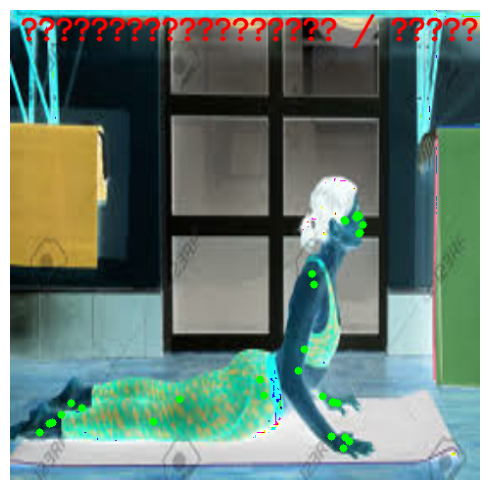

[2/5] ✅ 비라바드라사나1.jpg
   1) 우스트라사나 (0.3443)
   2) 할라사나 (0.3196)
   3) 나바사나 (0.2214)
   🧘‍♀️ 자세 점수 (vs 정답): 63.66점


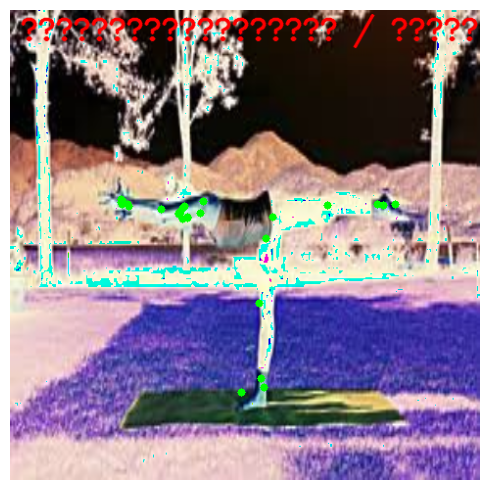

[3/5] ✅ 비라바드라사나2.jpg
   1) 우스트라사나 (0.5439)
   2) 나바사나 (0.2608)
   3) 할라사나 (0.1275)
   🧘‍♀️ 자세 점수 (vs 정답): 99.04점


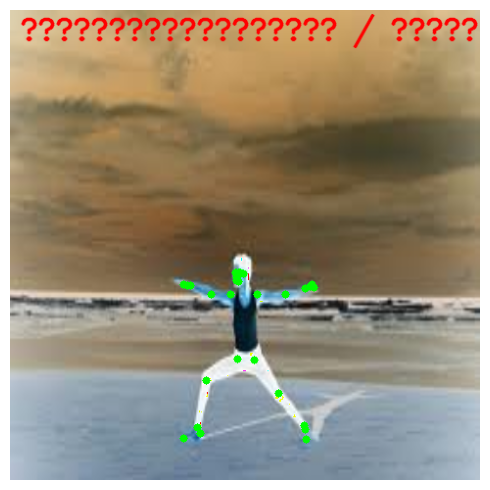

[4/5] ✅ 아도 무카 스바나사나.jpg
   1) 아도 무카 스바나사나 (0.8383)
   2) 우스트라사나 (0.1262)
   3) 나바사나 (0.0209)
   🧘‍♀️ 자세 점수 (vs 정답): 45.83점


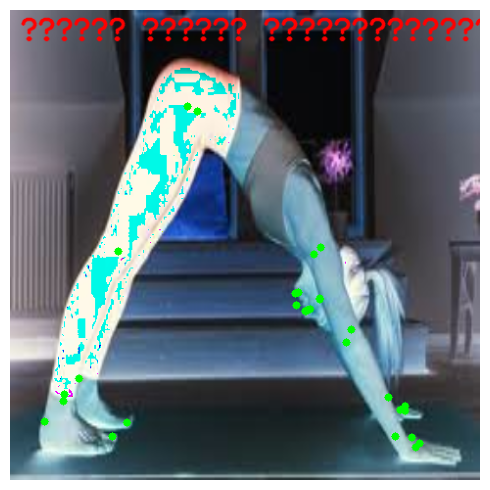

[5/5] ✅ 할라사나.jpg
   1) 할라사나 (0.9288)
   2) 나바사나 (0.0363)
   3) 아도 무카 스바나사나 (0.0264)
   🧘‍♀️ 자세 점수 (vs 정답): 17.01점


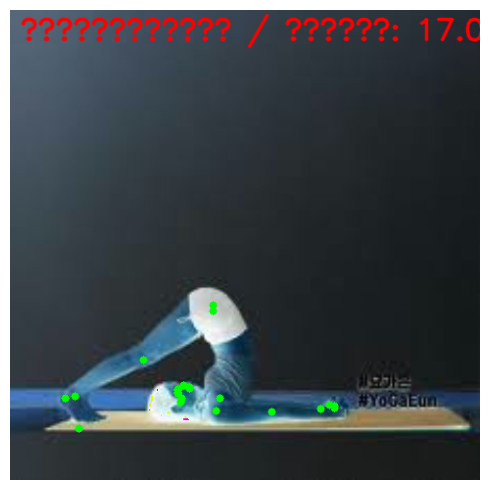


✅ 전체 예측 완료!


In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# ✅ 설정
IMAGE_DIR = '/content/testimage'
MODEL_PATH = '/content/drive/MyDrive/yoga/training/npz_output/all_poses_fixed_best_model.keras'
CSV_PATH = '/content/images/keypoints_all_norm.csv'
IMAGE_SIZE = 480
POSE_LABELS = ['할라사나', '나바사나', '아도 무카 스바나사나', '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']

# ✅ 모델 로딩
model = load_model(MODEL_PATH)

# ✅ 정답 CSV 불러오기
df = pd.read_csv(CSV_PATH)

# ✅ 기준 벡터 가져오기 함수
def get_reference_keypoint_vector(filename: str):
    row = df[df['filename'] == filename]
    if row.empty:
        return None
    vector = row.iloc[0].iloc[1:].values.astype(np.float32)
    return vector

# ✅ 유사도 점수 계산 함수 (Cosine Similarity)
def get_cosine_similarity_score(vec1, vec2):
    from numpy.linalg import norm
    if norm(vec1) == 0 or norm(vec2) == 0:
        return 0.0
    return round(np.dot(vec1, vec2) / (norm(vec1) * norm(vec2)) * 100, 2)

# ✅ Mediapipe 초기화
mp_pose = mp.solutions.pose
pose_detector = mp_pose.Pose(static_image_mode=True)

# ✅ 정규화 함수
# ✅ 정규화 함수 (min_scale 적용)
def normalize_keypoints_pelvis_shoulder(kpts, image_width=480, image_height=480,
                                        threshold=0.3, mask_value=-1.0, min_scale=20.0):
    x11, y11, v11 = kpts[11]
    x12, y12, v12 = kpts[12]
    x23, y23, v23 = kpts[23]
    x24, y24, v24 = kpts[24]

    x11, y11 = x11 * image_width, y11 * image_height
    x12, y12 = x12 * image_width, y12 * image_height
    x23, y23 = x23 * image_width, y23 * image_height
    x24, y24 = x24 * image_width, y24 * image_height

    if min(v11, v12, v23, v24) >= threshold:
        shoulder_center = np.array([(x11 + x12) / 2, (y11 + y12) / 2])
        hip_center = np.array([(x23 + x24) / 2, (y23 + y24) / 2])
        center = (shoulder_center + hip_center) / 2
        scale = max(np.linalg.norm(shoulder_center - hip_center), min_scale)  # ✅ 최소 스케일 보장
    else:
        center, scale = None, None

    vector = []
    for i in range(33):
        x, y, v = kpts[i]
        x *= image_width
        y *= image_height

        if v < threshold or center is None:
            x_out, y_out = mask_value, mask_value
        else:
            x_out = (x - center[0]) / scale
            y_out = (y - center[1]) / scale
        vector.extend([x_out, y_out, v])
    return np.array(vector, dtype=np.float32)


# ✅ keypoint 추출
def extract_keypoints_from_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None, None
    img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    results = pose_detector.process(img_rgb)

    if not results.pose_landmarks:
        return img_resized, None  # ✅ 항상 2개 반환

    keypoints = []
    for i in range(33):
        lm = results.pose_landmarks.landmark[i]
        keypoints.append([lm.x, lm.y, lm.visibility])
    return img_resized, np.array(keypoints)

def visualize_pose_with_score(image, keypoints, score, predicted_label, color=(0, 255, 0)):
    """
    이미지 위에 keypoint와 점수, 예측 라벨을 시각화합니다.
    """
    image_copy = image.copy()
    h, w = image.shape[:2]

    for i, (x, y, v) in enumerate(keypoints):
        if v > 0.3:
            cx, cy = int(x * w), int(y * h)
            cv2.circle(image_copy, (cx, cy), 4, color, -1)

    # 점수 및 예측 텍스트
    label_text = f'{predicted_label} / 점수: {score:.1f}'
    cv2.putText(image_copy, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1.0, (0, 0, 255), 2, cv2.LINE_AA)

    # matplotlib으로 이미지 출력
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# ✅ 예측 수행
files = sorted([f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

for idx, fname in enumerate(files, start=1):
    img_path = os.path.join(IMAGE_DIR, fname)
    img_input, kpts = extract_keypoints_from_image(img_path)

    if kpts is None:
        print(f"[{idx}/{len(files)}] ❌ Keypoint 실패: {fname}")
        continue

    kp_vector = normalize_keypoints_pelvis_shoulder(kpts)
    pred = model.predict({
        'image_input': np.expand_dims(img_input, axis=0),
        'keypoint_input': np.expand_dims(kp_vector, axis=0)
    }, verbose=0)

    top3_idx = np.argsort(pred[0])[::-1][:3]
    top3 = [(POSE_LABELS[i], float(pred[0][i])) for i in top3_idx]

    print(f"[{idx}/{len(files)}] ✅ {fname}")
    for rank, (label, score) in enumerate(top3, start=1):
        print(f"   {rank}) {label} ({score:.4f})")

    # 🔍 점수 계산
    reference_vector = get_reference_keypoint_vector(fname)
    if reference_vector is not None:
        score = get_cosine_similarity_score(kp_vector, reference_vector)
        print(f"   🧘‍♀️ 자세 점수 (vs 정답): {score:.2f}점")
    else:
        print("   ⚠️ 정답 기준 벡터 없음")
    image_for_vis = (img_input * 255).astype(np.uint8)
    visualize_pose_with_score(
    image=image_for_vis,  # 정규화 되어 있으니 다시 원상복구
    keypoints=kpts,
    score=score,
    predicted_label=top3[0][0]
)

print("\n✅ 전체 예측 완료!")


In [ ]:
import pandas as pd
import numpy as np

# 정답 CSV 파일 경로
csv_path = '/content/images/keypoints_all_norm.csv'
df = pd.read_csv(csv_path)

# 기준 포즈 벡터 추출 함수
def get_reference_keypoint_vector(filename: str):
    row = df[df['filename'] == filename]
    if row.empty:
        return None
    vector = row.iloc[0].iloc[1:].values.astype(np.float32)  # 첫 번째 행의 나머지 열 (x0~v32)
    return vector


In [ ]:
# 정답 기준 벡터 가져오기
reference_vector = get_reference_keypoint_vector(fname)

if reference_vector is not None:
    score = get_cosine_similarity_score(kp_vector, reference_vector)
    print(f"   🧘‍♀️ 자세 점수 (vs 정답): {score:.2f}점")
else:
    print("   ⚠️ 정답 기준 벡터 없음")


   ⚠️ 정답 기준 벡터 없음


In [ ]:
# 병합된 npz 전체에서 라벨 분포 확인
data = np.load('/content/drive/MyDrive/yoga/training/npz_output/all_poses_plus_fixed.npz')
unique, counts = np.unique(data['y'], return_counts=True)
print(dict(zip(unique, counts)))


{np.int32(0): np.int64(1742), np.int32(1): np.int64(1795), np.int32(2): np.int64(1771), np.int32(3): np.int64(1679), np.int32(4): np.int64(1736), np.int32(5): np.int64(1639), np.int32(6): np.int64(1744)}


In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ✅ 설정
IMAGE_DIR = '/content/'  # 이미지 폴더
MODEL_PATH = '/content/drive/MyDrive/yoga/training/npz_output/all_poses_plus_fixed_best_model_plus.keras'
LABELS = ['할라사나', '나바사나', '아도 무카 스바나사나', '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
IMAGE_SIZE = 480
VIS_THRESHOLD = 0.5
SAVE_DIR = '/content/misclassified'  # 잘못 예측한 이미지 저장 경로
os.makedirs(SAVE_DIR, exist_ok=True)

# ✅ 모델 및 Mediapipe 로딩
model = load_model(MODEL_PATH)
mp_pose = mp.solutions.pose
pose_detector = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

# ✅ keypoint 정규화 (골반+어깨 기준)
def normalize_keypoints(kpts, image_width=480, image_height=480, threshold=0.5, mask_value=-1.0):
    x11, y11, v11 = kpts[11]
    x12, y12, v12 = kpts[12]
    x23, y23, v23 = kpts[23]
    x24, y24, v24 = kpts[24]

    x11, y11 = x11 * image_width, y11 * image_height
    x12, y12 = x12 * image_width, y12 * image_height
    x23, y23 = x23 * image_width, y23 * image_height
    x24, y24 = x24 * image_width, y24 * image_height

    if min(v11, v12, v23, v24) >= threshold:
        shoulder_center = np.array([(x11 + x12) / 2, (y11 + y12) / 2])
        hip_center = np.array([(x23 + x24) / 2, (y23 + y24) / 2])
        center = (shoulder_center + hip_center) / 2
        scale = np.linalg.norm(shoulder_center - hip_center) + 1e-6
    else:
        center, scale = None, None

    vector = []
    for i in range(33):
        x, y, v = kpts[i]
        x *= image_width
        y *= image_height
        if v < threshold or center is None:
            x_out, y_out = mask_value, mask_value
        else:
            x_out = (x - center[0]) / scale
            y_out = (y - center[1]) / scale
        vector.extend([x_out, y_out, v])
    return np.array(vector, dtype=np.float32)

# ✅ 예측 및 시각화
def visualize_misclassified_images():
    files = sorted([f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    for idx, fname in enumerate(files, start=1):
        img_path = os.path.join(IMAGE_DIR, fname)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        results = pose_detector.process(img_rgb)

        if not results.pose_landmarks:
            continue

        kpts = []
        for lm in results.pose_landmarks.landmark:
            kpts.append([lm.x, lm.y, lm.visibility])
        kpts = np.array(kpts)

        kp_vector = normalize_keypoints(kpts)
        pred = model.predict({
            'image_input': np.expand_dims(img_resized.astype(np.float32) / 255.0, axis=0),
            'keypoint_input': np.expand_dims(kp_vector, axis=0)
        }, verbose=0)

        pred_class = int(np.argmax(pred))
        confidence = float(np.max(pred))
        label_name = LABELS[pred_class]

        # ✅ 실제 라벨이 filename에 포함된 경우만 비교
        true_label = None
        for i, name in enumerate(LABELS):
            if name in fname:
                true_label = i
                break

        if true_label is None or pred_class == true_label:
            continue  # 정답 or 라벨 모를 경우 건너뜀

        # ✅ 잘못 예측한 경우 → 시각화
        annotated = img_resized.copy()
        mp_drawing.draw_landmarks(annotated, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        text = f"Pred: {label_name} ({confidence:.2f}) | GT: {LABELS[true_label]}"
        cv2.putText(annotated, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        save_path = os.path.join(SAVE_DIR, f"wrong_{idx}_{fname}")
        cv2.imwrite(save_path, annotated)
        print(f"[{idx}] ❌ {fname} → {label_name} (GT: {LABELS[true_label]})")

    print("\n📦 잘못된 예측 이미지 저장 완료!")

# ✅ 실행
visualize_misclassified_images()


[3] ❌ 비라바드라사나1.jpg → 나바사나 (GT: 비라바드라사나1)
[4] ❌ 비라바드라사나2.jpg → 할라사나 (GT: 비라바드라사나2)
[6] ❌ 우스트라사나.jpg → 나바사나 (GT: 우스트라사나)
[7] ❌ 할라사나.jpg → 부장가사나 (GT: 할라사나)

📦 잘못된 예측 이미지 저장 완료!


In [ ]:
def feedback_halalasana(kpts):
    # keypoints: (33, 3) 형태의 np.array → x, y, visibility
    v_threshold = 0.5
    x = kpts[:, 0]
    y = kpts[:, 1]
    v = kpts[:, 2]

    # 필요한 포인트: 머리(0), 어깨(11/12), 골반(23/24), 발목(27/28)
    if min(v[0], v[11], v[12], v[23], v[24], v[27], v[28]) < v_threshold:
        return "⚠️ 포인트 인식이 불안정합니다. 자세 확인 불가"

    # 중심 계산
    shoulder_center_y = (y[11] + y[12]) / 2
    hip_center_y = (y[23] + y[24]) / 2
    ankle_avg_y = (y[27] + y[28]) / 2
    head_y = y[0]


    feedback = []
    if ankle_avg_y < head_y:
        feedback.append("✅ 다리가 충분히 올라갔습니다")
    else:
        feedback.append("❗ 다리가 머리보다 더 높게 올라가야 합니다")

    if hip_center_y < shoulder_center_y:
        feedback.append("✅ 골반 위치가 안정적입니다")
    else:
        feedback.append("❗ 골반을 더 들어 올려야 합니다")

    return "\n".join(feedback)


In [ ]:
!pip uninstall -y mediapipe numpy
!pip install --no-cache-dir numpy==1.24.3
!pip install --no-cache-dir mediapipe==0.10.14

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 225.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 172.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 379.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 238.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompa

In [ ]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 190.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 104.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4


In [ ]:
from PIL import Image

def load_and_resize_image(img_path, size=(640, 640)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(size)
    return np.array(img)  # dtype: uint8


In [ ]:
from tensorflow.keras.models import load_model

# 모델 경로
model_path = '/content/drive/MyDrive/yoga/training/npz_output/all_poses_fixed.npz'

# 모델 불러오기
model = load_model(model_path)


In [ ]:
import mediapipe as mp
import cv2

mp_pose = mp.solutions.pose
pose_detector = mp_pose.Pose(static_image_mode=True)

def extract_keypoints_from_blazepose(image):
    if isinstance(image, Image.Image):
        image = np.array(image)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    results = pose_detector.process(image_rgb)
    assert image.shape[-1] == 3

    if not results.pose_landmarks:
        raise ValueError("❌ keypoints가 감지되지 않았습니다.")

    keypoints = []
    for lm in results.pose_landmarks.landmark:
        keypoints.append({'x': lm.x, 'y': lm.y, 'visibility': lm.visibility})
    return keypoints


In [ ]:
def preprocess_keypoints_for_prediction(keypoints, image_width=640, image_height=640,
                                        visibility_threshold=0.5, mask_value=-1.0):
    vector = []
    x11 = keypoints[11]['x'] * image_width
    x12 = keypoints[12]['x'] * image_width
    y11 = keypoints[11]['y'] * image_height
    y12 = keypoints[12]['y'] * image_height
    v11, v12 = keypoints[11]['visibility'], keypoints[12]['visibility']

    if v11 >= visibility_threshold and v12 >= visibility_threshold:
        x_center = (x11 + x12) / 2
        y_center = (y11 + y12) / 2
        scale = np.linalg.norm([x11 - x12, y11 - y12]) + 1e-6
    else:
        x_center, y_center, scale = None, None, None

    for i in range(33):
        kp = keypoints[i]
        x = kp['x'] * image_width
        y = kp['y'] * image_height
        v = kp['visibility']
        if v < visibility_threshold or x_center is None:
            vector.extend([mask_value, mask_value, v])
        else:
            x_out = (x - x_center) / scale
            y_out = (y - y_center) / scale
            vector.extend([x_out, y_out, v])
    return np.array(vector, dtype=np.float32)


In [ ]:
def predict_pose(model, X_img, X_pose, label_map=None):
    preds = model.predict({'image_input': X_img, 'keypoint_input': X_pose})
    pred_class = np.argmax(preds, axis=1)[0]
    confidence = np.max(preds, axis=1)[0]
    label_name = label_map[pred_class] if label_map else str(pred_class)
    return label_name, pred_class, confidence



In [ ]:
def predict_pose_top3(model, X_img, X_pose, label_map=None, top_k=3):
    """
    Top-k 예측 결과 반환

    Returns:
        List of (label index, label name, confidence)
    """
    preds = model.predict({'image_input': X_img, 'keypoint_input': X_pose})  # shape (1, 7)
    preds = preds[0]  # (7,)

    top_indices = preds.argsort()[-top_k:][::-1]
    results = []

    for idx in top_indices:
        label_name = label_map[idx] if label_map else str(idx)
        confidence = preds[idx]
        results.append((idx, label_name, confidence))

    return results


In [ ]:
# 🔁 예측 이미지 목록
test_img_paths = [
    "/content/할라사나.jpg",
    "/content/나바사나.jpg",
    "/content/우스트라사나.jpg",
    "/content/비라바드라사나2.jpg",
    "/content/부장가사나.jpg",
    "/content/아도 무카 스바나사나.jpg",
    "/content/비라바드라사나1.jpg"
]

for img_path in test_img_paths:
    try:
        image_raw = load_and_resize_image(img_path)
        keypoints = extract_keypoints_from_blazepose(image_raw)
        X_img = np.expand_dims(image_raw / 255.0, axis=0)
        X_pose = np.expand_dims(preprocess_keypoints_for_prediction(keypoints), axis=0)

        top_preds = predict_pose_top3(model, X_img, X_pose, label_map)

        print(f"\n🖼️ [{os.path.basename(img_path)}] 예측 결과:")
        for rank, (idx, name, conf) in enumerate(top_preds, start=1):
            print(f"  {rank}위: {name} ({idx}) - 신뢰도: {conf:.3f}")

    except Exception as e:
        print(f"❌ [{os.path.basename(img_path)}] 처리 실패: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

🖼️ [할라사나.jpg] 예측 결과:
  1위: 비라바드라사나1 (5) - 신뢰도: 0.669
  2위: 부장가사나 (4) - 신뢰도: 0.298
  3위: 나바사나 (1) - 신뢰도: 0.025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

🖼️ [나바사나.jpg] 예측 결과:
  1위: 나바사나 (1) - 신뢰도: 1.000
  2위: 부장가사나 (4) - 신뢰도: 0.000
  3위: 할라사나 (0) - 신뢰도: 0.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

🖼️ [우스트라사나.jpg] 예측 결과:
  1위: 부장가사나 (4) - 신뢰도: 0.974
  2위: 우스트라사나 (3) - 신뢰도: 0.019
  3위: 비라바드라사나1 (5) - 신뢰도: 0.003
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

🖼️ [비라바드라사나2.jpg] 예측 결과:
  1위: 부장가사나 (4) - 신뢰도: 0.989
  2위: 나바사나 (1) - 신뢰도: 0.004
  3위: 우스트라사나 (3) - 신뢰도: 0.003
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

🖼️ [부장가사나.jpg] 예측 결과:
  1위: 부장가사나 (4) - 신뢰도: 0.992
  2위: 할라사나 (0) - 신뢰도: 0.007
  3위: 나바사나 (1) - 신뢰도: 0.001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

🖼️ [아도 무카 스바나사나.jpg] 예측 결과:
  1위: 비라바드라사나1 (5) - 신뢰도: 0.543
  2위: 부장가사나 (4) - 신뢰도: 0.247
  3위: 아도 무카 스바나사나 (2) - 신뢰도: 0.148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

🖼️ [비라바드라사나1.jpg] 예측 결과:
  1위: 비라바드라사나1 (5) - 신뢰도: 0.6

In [ ]:
import tensorflow as tf

# ✅ 모델 로드
model_path = "/content/drive/MyDrive/yoga/training/npz_output/all_poses_plus_fixed_best_model_plus.keras"
model = tf.keras.models.load_model(model_path)

# ✅ 변환기 초기화
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# ✅ 최적화 옵션 (선택: 경량화 목적)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# ✅ 변환 실행
tflite_model = converter.convert()

# ✅ 저장
tflite_path = model_path.replace('.keras', '.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"✅ TFLite 모델 저장 완료: {tflite_path}")


Saved artifact at '/tmp/tmpp688k0x1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 480, 480, 3), dtype=tf.float32, name='image_input'), TensorSpec(shape=(None, 99), dtype=tf.float32, name='keypoint_input')]
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138218512862096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218512863440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218512861136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218512865168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218512859216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218512864784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218512863056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218512866128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218512862288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13821851

## keypoint만으로 학습해보기

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터 분할
X_pose_train, X_pose_val, y_train, y_val = train_test_split(
    X_pose, y, test_size=0.2, stratify=y, random_state=42
)

# 모델 정의 및 학습
def train_keypoint_only_split(X_train, X_val, y_train, y_val, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(99,)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        verbose=1
    )
    return model, history

# 실행
model, history = train_keypoint_only_split(
    X_pose_train, X_pose_val, y_train, y_val, num_classes=7
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6634 - loss: 1.1345 - val_accuracy: 0.9955 - val_loss: 0.0391
Epoch 2/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9644 - loss: 0.1260 - val_accuracy: 0.9992 - val_loss: 0.0109
Epoch 3/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9826 - loss: 0.0598 - val_accuracy: 0.9996 - val_loss: 0.0050
Epoch 4/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9867 - loss: 0.0462 - val_accuracy: 0.9996 - val_loss: 0.0031
Epoch 5/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9912 - loss: 0.0309 - val_accuracy: 0.9996 - val_loss: 0.0021
Epoch 6/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9938 - loss: 0.0244 - val_accuracy: 0.9996 - val_loss: 0.0017
Epoch 7/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9930 - loss: 0.0216 - val_accuracy: 0.9996 - val_loss: 0.0016
Epoch 8/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9946 - loss: 0.0195 - val_accuracy: 0.9996 - val_